In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append('../module/')

In [2]:
data = np.genfromtxt('../testdata/Coordinates.csv', delimiter=',')
conn = np.genfromtxt('../testdata/Connectivity.csv', delimiter=',', dtype=np.int) - 1
X = data[:, 0]; Y = data[:, 1]; Z = data[:, 2];
tet = np.zeros((conn.shape[0], 4, 4))
coord = data[conn]
print(coord.shape)
tet[:,:-1,:-1] = data[conn]
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print(vol, r0)
r0 = 5.272
mu = 1.
nu = 0.499

(14759, 3, 3)
620.889788674 5.29226971395


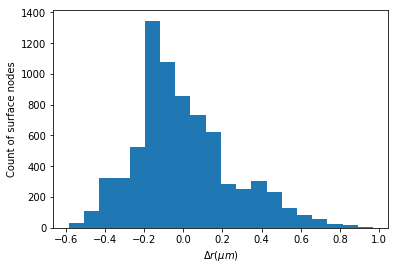

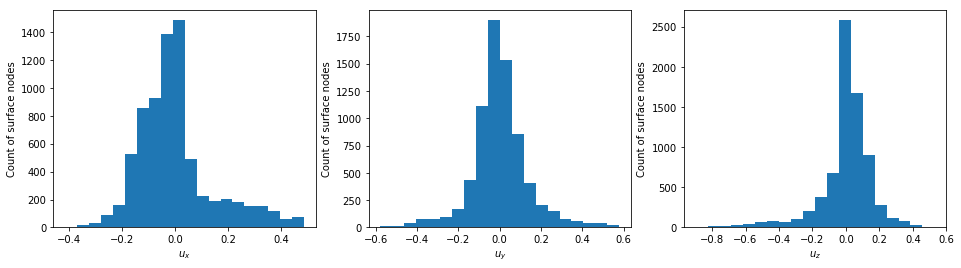

In [3]:
R = np.sqrt(X**2+Y**2+Z**2)
THETA = np.arccos(Z/R)
PHI = np.arctan2(Y, X)
PHI[PHI < 0] += 2*np.pi
ux = -(r0-R)*X/R
uy = -(r0-R)*Y/R
uz = -(r0-R)*Z/R
plt.hist(r0-R, bins=20)
plt.xlabel(r'$\Delta r(\mu m)$')
plt.ylabel('Count of surface nodes')
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.hist(ux, bins=20)
plt.xlabel(r'$u_x$')
plt.ylabel('Count of surface nodes')
plt.subplot(132)
plt.hist(uy, bins=20)
plt.xlabel(r'$u_y$')
plt.ylabel('Count of surface nodes')
plt.subplot(133)
plt.hist(uz, bins=20)
plt.xlabel(r'$u_z$')
plt.ylabel('Count of surface nodes')
plt.show()

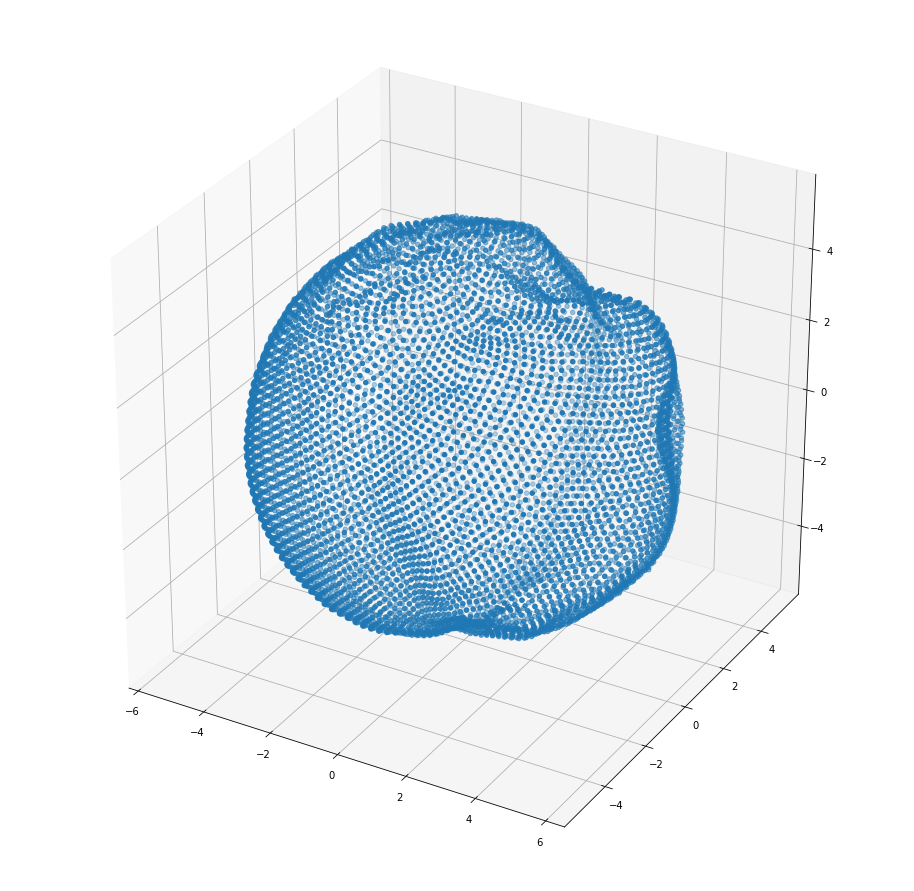

In [4]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(X, Y, Z)
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from SHUtil import SHCilmToVector, lmk2K, K2lmk
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from ShElastic import calSmode
from SHBV import generate_submat, visualize_Cmat

In [6]:
#### full Dmat info ####
lJmax = 15 # max l degree for saving a single mode
lKmax = 12 # max cutoff l degree for modes
LJ = (lJmax+1)**2
LK = (lKmax+1)**2

#### create meshgrid for evaluation ####
Ngrid = 50
latglq, longlq = pyshtools.expand.GLQGridCoord(lJmax)
theta = np.radians(90-latglq)
phi = np.radians(longlq)
#zero, w = pyshtools.expand.SHGLQ(lmax_sub)

TT, PP = np.meshgrid(theta, phi)
ZZ = np.cos(TT)
XX = np.sin(TT)*np.cos(PP)
YY = np.sin(TT)*np.sin(PP)
RR = np.sqrt(XX**2+YY**2+ZZ**2)
NN = np.stack((XX/RR, YY/RR, ZZ/RR), axis=-1)

Q = np.zeros(TT.shape+(3,3))
Q[...,0,0] = np.sin(TT)*np.cos(PP)
Q[...,0,1] = np.sin(TT)*np.sin(PP)
Q[...,0,2] = np.cos(TT)
Q[...,1,0] = np.cos(TT)*np.cos(PP)
Q[...,1,1] = np.cos(TT)*np.sin(PP)
Q[...,1,2] =-np.sin(TT)
Q[...,2,0] =-np.sin(PP)
Q[...,2,1] = np.cos(PP)

Test the nearest interpolation algorithm

(496, 3) (496,)


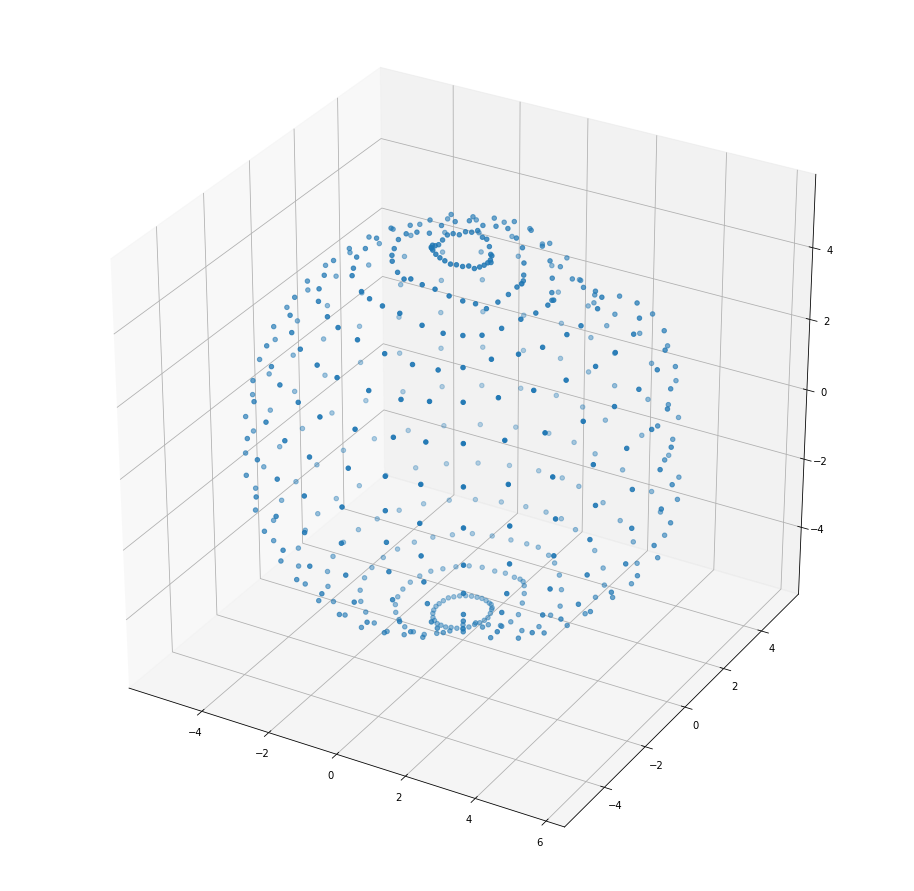

(31, 16) (31, 16) (31, 16)


In [7]:
from scipy.interpolate import griddata
newgrid = np.stack([XX.ravel(), YY.ravel(), ZZ.ravel()], axis=-1)
xyz = data/R[:,np.newaxis]
r_grid = griddata(xyz, R, newgrid, method='nearest')

print(newgrid.shape, r_grid.shape)
newx = newgrid[:, 0]*r_grid
newy = newgrid[:, 1]*r_grid
newz = newgrid[:, 2]*r_grid
#print(newgrid)

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(newx, newy, newz)
plt.show()

Ux = (-(r0-r_grid)*newx/r_grid).reshape(XX.shape)
#griddata(xyz, ux, newgrid, method='nearest').reshape(XX.shape)
Uy = (-(r0-r_grid)*newy/r_grid).reshape(YY.shape)
#griddata(xyz, uy, newgrid, method='nearest').reshape(YY.shape)
Uz = (-(r0-r_grid)*newz/r_grid).reshape(ZZ.shape)
#griddata(xyz, uz, newgrid, method='nearest').reshape(ZZ.shape)
print(Ux.shape, Uy.shape, Uz.shape)

In [8]:
def plotfv(fv, figsize=(10,5),colorbar=True, show=True):
    fmax, fmin = fv.max(), fv.min()
    fcolors = (fv - fmin)/(fmax - fmin)    # normalize the values into range [0, 1]
    fig0 = plt.figure(figsize=figsize)
    ax0 = fig0.add_subplot(111)
    cax0 = ax0.imshow(fv, extent=(0, 360, -90, 90), cmap='viridis')
    ax0.set(xlabel='longitude', ylabel='latitude')
    if colorbar:
        fig0.colorbar(cax0)
    if show:
        plt.show()
    return fig0, ax0

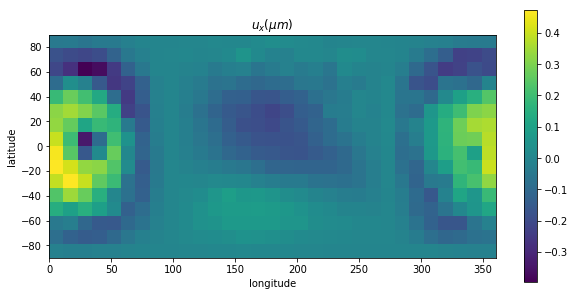

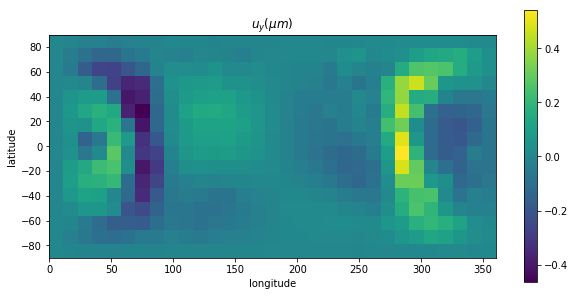

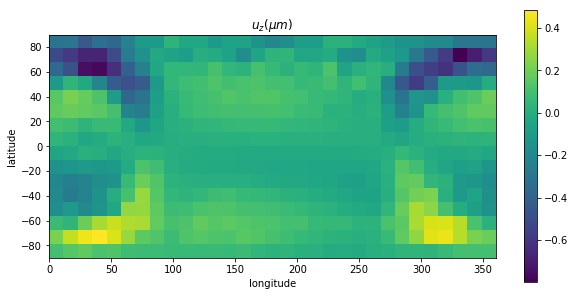

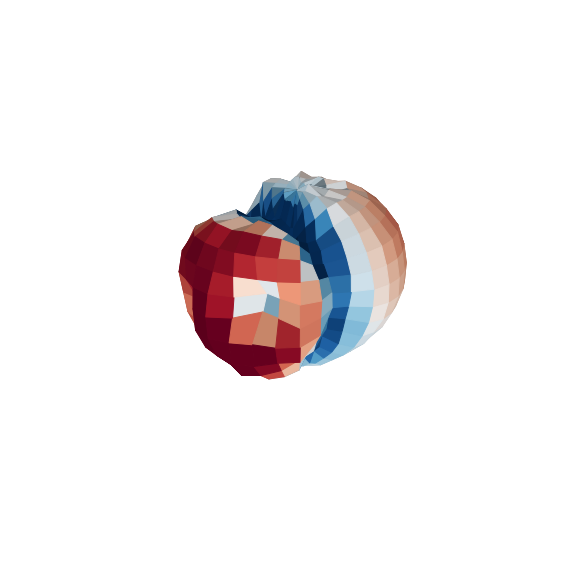

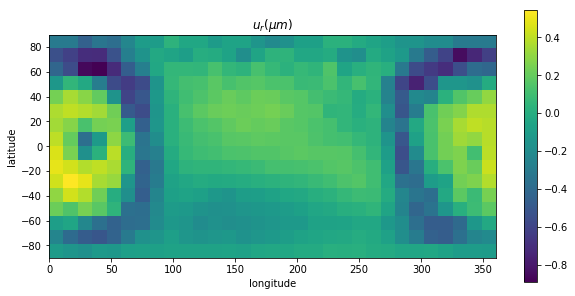

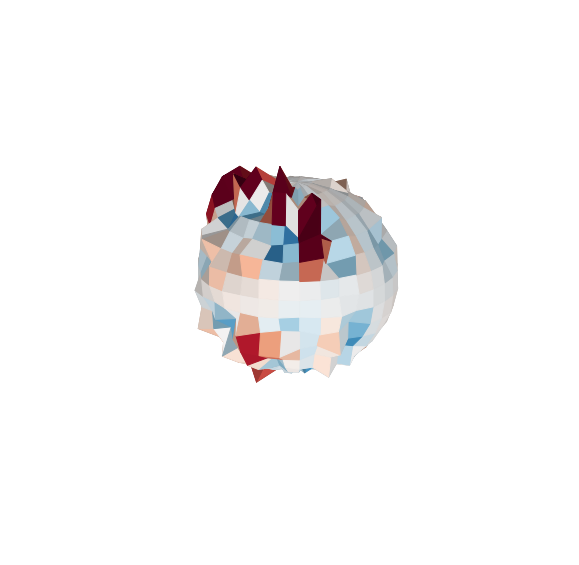

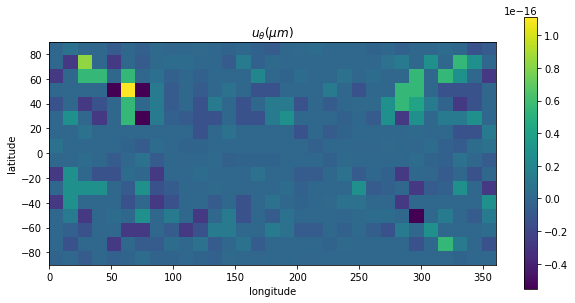

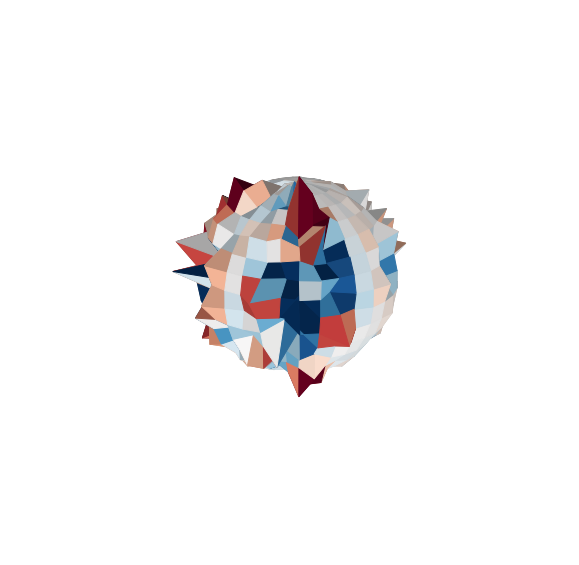

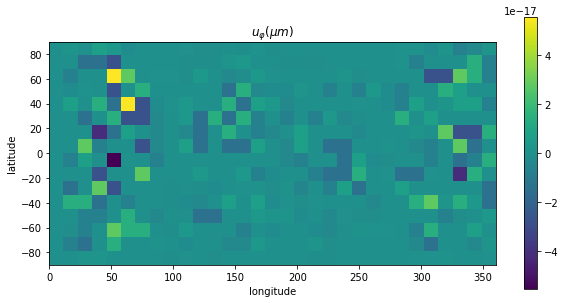

In [9]:
U_usr_mesh = np.zeros(TT.shape+(3,))

U_usr_mesh[...,0] = Ux
U_usr_mesh[...,1] = Uy
U_usr_mesh[...,2] = Uz

U_usr_vec = np.array([])
ttl = 'xyz'
for k in range(3):
    U_usr_grid = pyshtools.SHGrid.from_array(U_usr_mesh[...,k].T.astype(np.complex), grid='GLQ')
    U_usr_cilm = U_usr_grid.expand()
    fig, ax = plotfv(U_usr_grid.to_array().real, show=False)
    ax.set_title(r'$u_%c (\mu m)$' % ttl[k])
    U_usr_vec = np.hstack((U_usr_vec, SHCilmToVector(U_usr_cilm.to_array(), lmax = lJmax)))
plt.show()

U_sph_mesh = np.sum(Q*U_usr_mesh[...,np.newaxis,:], axis=-1)
rtp = ['r',r'\theta',r'\varphi']
for k in range(3):
    U_sph_grid = pyshtools.SHGrid.from_array(U_sph_mesh[...,k].T.real, grid='GLQ')
    U_sph_grid.plot3d(elevation=20,azimuth=45)
    fig, ax = plotfv(U_sph_mesh[...,k].T.real, show=False)
    ax.set_title(r'$u_%s (\mu m)$' % rtp[k])
plt.show()

In [10]:
from ShElastic import calUmode

shtype = 'reg'
Umodes = loadmat('Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
print(Umodes[0].shape, 3*54**2)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax)

(1728, 1323) 8748


In [11]:
import time
import scipy.sparse as spm
from SHBV import print_SH_mode
tic = time.time()
B = spm.linalg.lsqr(Dmat, U_usr_vec.transpose())
toc = time.time()
print('Residual:', B[3], 'Time:', toc-tic)
B_sol = B[0]
print('Solution:', B_sol.size)
print(U_usr_vec.T-np.dot(Dmat.todense(), B[0]))
disp_index_sol = print_SH_mode(B_sol, m_dir=3, etol=1e-8)

Residual: 0.03190671530697028 Time: 0.040583133697509766
Solution: 507
[[ -1.29998318e-10 +2.33111273e-12j   2.15591434e-13 +3.70042452e-12j
    3.08321077e-12 +7.68881486e-14j   9.76232983e-14 +3.70091241e-12j
   -2.44906664e-10 +1.04025822e-10j  -3.20164464e-10 +7.53099701e-11j
   -4.10235380e-10 -2.70820432e-12j   3.21445376e-10 +7.91684895e-11j
   -2.64261248e-10 -8.17880286e-11j  -7.19287754e-11 +9.48041125e-13j
    3.40262939e-11 +3.48247928e-12j  -4.17969062e-11 -1.95227471e-11j
   -1.32564601e-10 +4.23454674e-14j   4.40567027e-11 -1.63240879e-11j
    3.77030681e-11 -1.98458025e-12j   7.03943154e-11 -4.72422015e-12j
   -1.65297919e-09 +4.55609207e-10j  -6.43165402e-11 +3.54166202e-10j
   -6.48380703e-10 +9.79727367e-12j   1.89563697e-09 -1.48652614e-10j
    1.52203880e-09 +1.13579081e-11j  -1.89097820e-09 -1.43578203e-10j
   -6.55748605e-10 -4.04308956e-11j   6.13868672e-11 +3.97231928e-10j
   -1.75000850e-09 -3.57991583e-10j  -7.14879849e-10 +1.95459887e-10j
    5.78180262e-11 

index: 15 (3, 3, 0) coeff: (-0.178003300235+0.00455654872918j)
index: 16 (4, -4, 0) coeff: (-0.156851336441+0.0248911130841j)
index: 17 (4, -3, 0) coeff: (0.00297222043416-0.0282686525531j)
index: 18 (4, -2, 0) coeff: (0.166098984092+0.00812550081072j)
index: 19 (4, -1, 0) coeff: (-0.00641222600313-0.000152041420992j)
index: 20 (4, 0, 0) coeff: (-0.165174966556-1.86274941671e-11j)
index: 21 (4, 1, 0) coeff: (0.0064122258071-0.00015204137448j)
index: 22 (4, 2, 0) coeff: (0.166098984059-0.00812550110876j)
index: 23 (4, 3, 0) coeff: (-0.00297222036692-0.028268652663j)
index: 24 (4, 4, 0) coeff: (-0.15685133686-0.0248911125709j)
index: 25 (5, -5, 0) coeff: (-0.03853772376+0.0140085826606j)
index: 26 (5, -4, 0) coeff: (-0.000432444956986+0.021070867067j)
index: 27 (5, -3, 0) coeff: (-0.0264160087699-0.0113278533807j)
index: 28 (5, -2, 0) coeff: (0.0260235108422-0.00897088592984j)
index: 29 (5, -1, 0) coeff: (0.0620627795087+0.000372475695761j)
index: 30 (5, 0, 0) coeff: (-0.0150243227933+1.

index: 194 (5, -5, 1) coeff: (0.0120282343479+0.00399872490463j)
index: 195 (5, -4, 1) coeff: (-0.00121784940686-0.0029592814975j)
index: 196 (5, -3, 1) coeff: (-0.0224384983918+0.0106415890521j)
index: 197 (5, -2, 1) coeff: (-0.00586389912729-0.00251484765907j)
index: 198 (5, -1, 1) coeff: (0.000372475684541-0.00126177720884j)
index: 199 (5, 0, 1) coeff: (-0.000184220701902-4.6351347935e-11j)
index: 200 (5, 1, 1) coeff: (-0.000372475684388-0.00126177719228j)
index: 201 (5, 2, 1) coeff: (-0.00586389917248+0.00251484756581j)
index: 202 (5, 3, 1) coeff: (0.022438498562+0.0106415890475j)
index: 203 (5, 4, 1) coeff: (-0.0012178495462+0.00295928146213j)
index: 204 (5, 5, 1) coeff: (-0.0120282344505+0.00399872488946j)
index: 205 (6, -6, 1) coeff: (-0.0196340593598-0.0292158755651j)
index: 206 (6, -5, 1) coeff: (-0.00275624989778-0.00394878580324j)
index: 207 (6, -4, 1) coeff: (0.021388351627+0.00439529105774j)
index: 208 (6, -3, 1) coeff: (-0.0041114303024-0.0110136536933j)
index: 209 (6, -2

In [12]:
from SHBV import fast_stress_solution

Smodes = loadmat('Smodes.mat')
Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
fullSmodes = calSmode(Smodes, mu, nu)
Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9, lJfull=23, lKfull=20)

tic = time.time()
sigma_tot = fast_stress_solution(B_sol, XX, YY, ZZ, Smodes, lKmax, lJmax, shtype=shtype)
toc = time.time()
print(sigma_tot.shape, toc-tic)

T_sol = np.sum(sigma_tot*NN[...,np.newaxis,:], axis=-1)

#for k in range(3):
#    T_sol_grid = pyshtools.SHGrid.from_array(T_sol[...,k].T, grid='GLQ')
#    T_sol_grid.plot()#3d(elevation=20, azimuth=-45)

(31, 16, 3, 3) 0.5710973739624023


(31, 16)
(31, 16)
(31, 16)


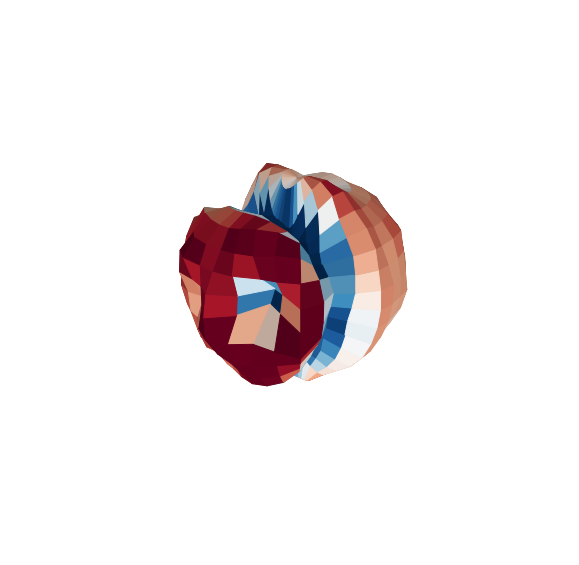

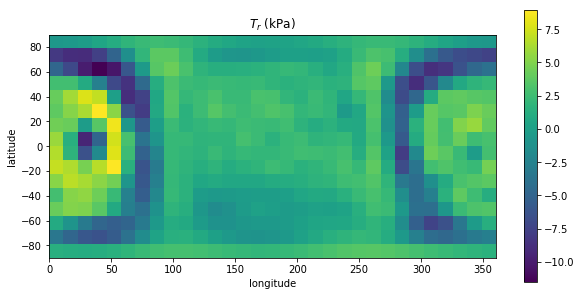

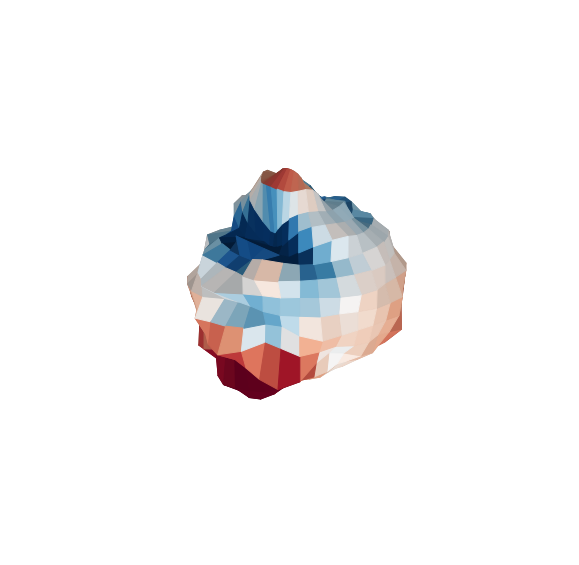

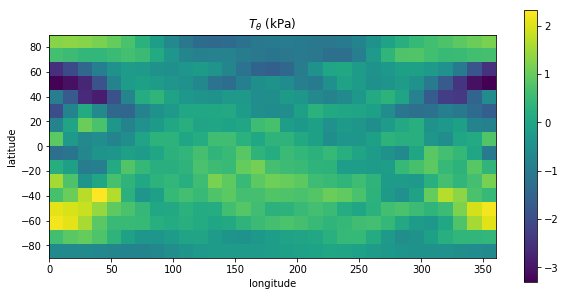

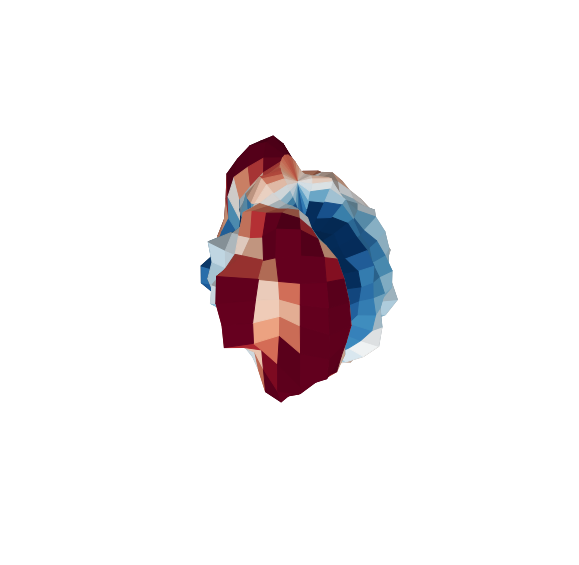

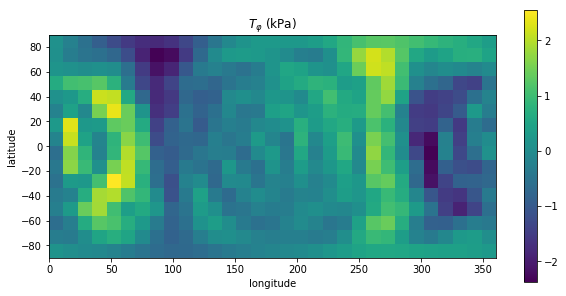

In [13]:
T_sol = np.sum(sigma_tot*NN[...,np.newaxis,:], axis=-1)*4/3
#T_norm= np.linalg.norm(T_sol, axis=-1)
#fig, ax = plotfv(T_norm.T.real, show=False)
#ax.set_title(r'$T_%c$' % ttl[k])

for k in range(3):
    print(T_sol[...,k].shape)
    T_sol_grid = pyshtools.SHGrid.from_array(T_sol[...,k].T.astype(np.complex), grid='GLQ') 
    #fig, ax = plotfv(T_sol_grid.to_array().real, show=False)
    #ax.set_title(r'$T_%c $(kPa)' % ttl[k])
#plt.show()

T_sph_mesh = np.sum(Q*T_sol[...,np.newaxis,:], axis=-1)
for k in range(3):
    T_sph_grid = pyshtools.SHGrid.from_array(T_sph_mesh[...,k].T.real, grid='GLQ')
    T_sph_grid.plot3d(elevation=20,azimuth=45)
    fig, ax = plotfv(T_sph_mesh[...,k].T.real, show=False)
    ax.set_title(r'$T_%s$ (kPa)' % rtp[k])
plt.show()

In [14]:
from SHBV import fast_displacement_solution
from ShElastic import calUmode

Umodes = loadmat('Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullUmodes = calUmode(Umodes, mu, nu)
Umodes = generate_submat(mu, nu, fullUmodes, lKmax, lJmax, lJfull=23, lKfull=20)

tic = time.time()
disp_sol = fast_displacement_solution(B_sol, XX, YY, ZZ, Umodes, lKmax=lKmax, lJmax=lJmax, shtype=shtype)
toc = time.time()
print('group modes by l', toc-tic)

group modes by l 0.20255351066589355


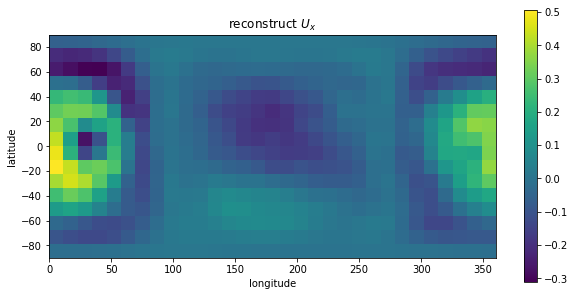

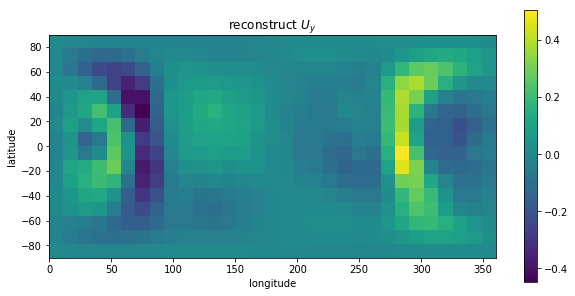

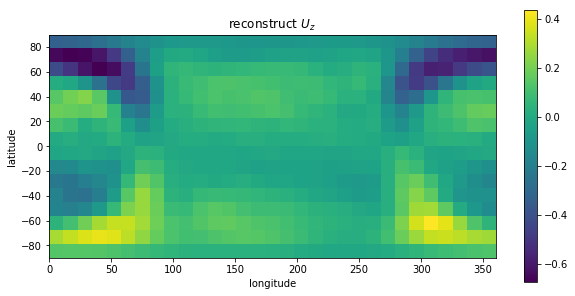

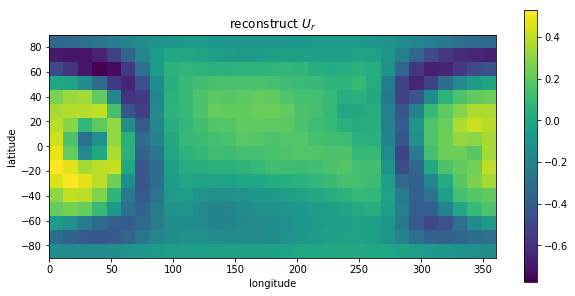

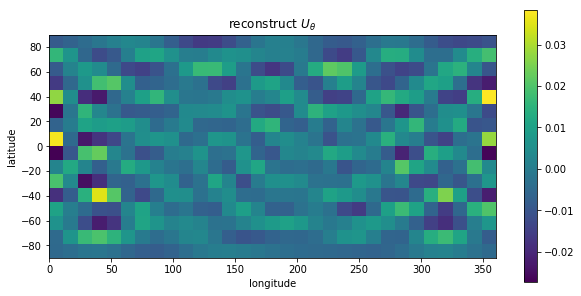

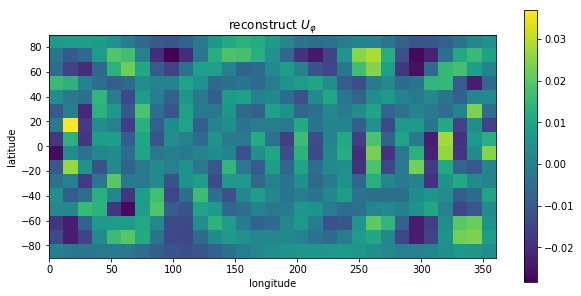

In [15]:
U_sol_mesh = disp_sol

for k in range(3):
    U_sol_grid = pyshtools.SHGrid.from_array(U_sol_mesh[...,k].T.astype(np.complex), grid='GLQ')
    fig,ax = plotfv(U_sol_grid.to_array().real, show=False)
    ax.set_title('reconstruct $U_%c$' % ttl[k])
plt.show()

U_sol_sph = np.sum(Q*disp_sol[...,np.newaxis, :], axis=-1)
for k in range(3):
    fig,ax = plotfv(U_sol_sph[...,k].T.real, show=False)
    ax.set_title('reconstruct $U_%s$' % rtp[k])
plt.show()

In [30]:
from SHBV import fast_energy_solution

fast_energy_solution(B[0], Dmat, Cmat)

1.2259962118625771

## Energy minimization

We first define a function that calculates elastic energy of the sphere given displacement.

In [85]:
from SHBV import fast_energy_solution
from SHUtil import SphCoord_to_CartCoord

def E_disp(U0, Dmat, Cmat, data, lKmax=20, lJmax=23):
    LJ = (lJmax+1)**2
    X = data[..., 0]; Y = data[..., 1]; Z = data[..., 2];
    #print(data.shape[:-1] + (2,))
    U0 = U0.reshape(data.shape[:-1] + (2,))
    #print(U0.shape)
    THETA = U0[...,0]; PHI = U0[...,1]; r0 = 5.272;
    X0,Y0,Z0 = SphCoord_to_CartCoord(r0, THETA, PHI)

    U_usr_mesh = np.stack([X-X0, Y-Y0, Z-Z0], axis=-1)
    #print(U_usr_mesh.shape)
    U_usr_vec = np.empty(3*LJ, dtype=np.complex)
    for k in range(3):
        U_usr_grid = pyshtools.SHGrid.from_array(U_usr_mesh[...,k].T.astype(np.complex), grid='GLQ')
        U_usr_cilm = U_usr_grid.expand()
        U_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(U_usr_cilm.to_array(), lmax = lJmax)
    B = spm.linalg.lsqr(Dmat, U_usr_vec.transpose())
    #B_sol=print_SH_mode(B[0], m_dir=3, etol=1e-8)
    return fast_energy_solution(B[0], Dmat, Cmat)

In [86]:
from ShElastic import calSmode

shtype = 'reg'
Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
#print(Umodes[0].shape, 3*54**2)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)

In [87]:
from scipy.optimize import minimize
#from SHBV import E_disp

tic = time.time()
init = np.stack([TT, PP], axis=-1)
newdata = np.stack([newx,newy,newz], axis=-1).reshape(TT.shape+(3,))
Ep = E_disp(init.flatten(), Dmat, Cmat, newdata, lKmax, lJmax)
toc = time.time()
print(Ep, toc-tic)

1.2259962105 0.024821996688842773


In [90]:
tic = time.time()
res_CG = minimize(E_disp, init.flatten(), args=(Dmat, Cmat, newdata, lKmax, lJmax))
toc = time.time()

In [91]:
print(res_CG, toc-tic)

      fun: 1.2259962105043556
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([  3.23534310e-02,  -5.21673858e-02,   1.50843263e-01,
         5.88326305e-02,   2.67402560e-01,   1.98044479e-02,
         2.18791708e-01,   1.17902115e-01,   2.86598653e-02,
        -6.08141720e-03,   2.67710268e-01,   9.73076373e-02,
         2.40948483e-01,   7.12998658e-02,   7.70279318e-02,
         2.76742324e-01,   2.68083826e-01,   1.78485781e-01,
         1.54641345e-01,   1.08293459e-01,  -2.41087437e-01,
         1.40048787e-01,   1.67519629e-01,   2.59648651e-01,
         3.64664644e-02,   2.65985101e-01,   7.94182867e-02,
         1.56138539e-01,  -3.84610742e-02,   2.17350885e-01,
         5.84219098e-02,   1.23926386e-01,   1.23096585e-01,
        -4.30261344e-02,   5.19111603e-02,   3.93584669e-02,
         1

In [83]:
print(E_disp(res.x, Dmat, Cmat, newdata, lKmax, lJmax))

index: 0 (0, 0, 0) coeff: (-0.012671789194+9.48578599487e-13j)
index: 1 (1, -1, 0) coeff: (594.375898343-8.1713405573j)
index: 2 (1, 0, 0) coeff: (72.6745545334+1.11694762741e-12j)
index: 3 (1, 1, 0) coeff: (-594.375898343-8.17134055733j)
index: 4 (2, -2, 0) coeff: (0.3797639584-0.0795321474053j)
index: 5 (2, -1, 0) coeff: (-0.0641344626275+0.146507352236j)
index: 6 (2, 0, 0) coeff: (-0.302577866827+6.74991842172e-11j)
index: 7 (2, 1, 0) coeff: (0.0641344629605+0.146507352345j)
index: 8 (2, 2, 0) coeff: (0.37976395803+0.0795321469726j)
index: 9 (3, -3, 0) coeff: (0.621267303024+0.00461127338059j)
index: 10 (3, -2, 0) coeff: (0.0464593263762-0.0473786529583j)
index: 11 (3, -1, 0) coeff: (-0.0314587261312-0.0221962053387j)
index: 12 (3, 0, 0) coeff: (-0.11331598474-7.30788882426e-11j)
index: 13 (3, 1, 0) coeff: (0.031458725783-0.0221962053953j)
index: 14 (3, 2, 0) coeff: (0.0464593262533+0.0473786532111j)
index: 15 (3, 3, 0) coeff: (-0.621267302082+0.0046112732116j)
index: 16 (4, -4, 0) 

index: 216 (6, 5, 1) coeff: (0.00275570450586-0.00390284208117j)
index: 217 (6, 6, 1) coeff: (-0.0196671930713+0.0267731375596j)
index: 218 (7, -7, 1) coeff: (0.0103602065011+0.0302725403357j)
index: 219 (7, -6, 1) coeff: (-0.0048512501158+0.00618828820498j)
index: 220 (7, -5, 1) coeff: (-0.0122052825322-0.0220681629663j)
index: 221 (7, -4, 1) coeff: (0.00621468701066-0.00117880088293j)
index: 222 (7, -3, 1) coeff: (0.0131059489578-0.00877442675769j)
index: 223 (7, -2, 1) coeff: (-0.00540433359772-0.00441900770702j)
index: 224 (7, -1, 1) coeff: (-0.00312516209417+0.00365386561005j)
index: 225 (7, 0, 1) coeff: (0.00165167176754+6.32412114942e-11j)
index: 226 (7, 1, 1) coeff: (0.00312516197264+0.00365386560028j)
index: 227 (7, 2, 1) coeff: (-0.0054043335643+0.00441900776383j)
index: 228 (7, 3, 1) coeff: (-0.0131059488557-0.00877442676995j)
index: 229 (7, 4, 1) coeff: (0.00621468703124+0.00117880085494j)
index: 230 (7, 5, 1) coeff: (0.0122052826294-0.0220681631072j)
index: 231 (7, 6, 1) c

index: 497 (12, 3, 2) coeff: (0.00125077932514-0.00297093065641j)
index: 498 (12, 4, 2) coeff: (-6.81062097895e-05+0.00076561151942j)
index: 499 (12, 5, 2) coeff: (0.000348365964743-0.00137208967162j)
index: 500 (12, 6, 2) coeff: (-0.000995324597122+0.00170726372158j)
index: 501 (12, 7, 2) coeff: (-0.00222856213696+0.0014222910485j)
index: 502 (12, 8, 2) coeff: (-0.000794609480869-0.00543935674315j)
index: 503 (12, 9, 2) coeff: (0.000858680683945+0.00103708968856j)
index: 504 (12, 10, 2) coeff: (-0.00126006958015+0.00230443967743j)
index: 505 (12, 11, 2) coeff: (-3.1878255269e-05+0.000557132415656j)
index: 506 (12, 12, 2) coeff: (-0.000136162635237-3.09999398839e-05j)
-148658.687653


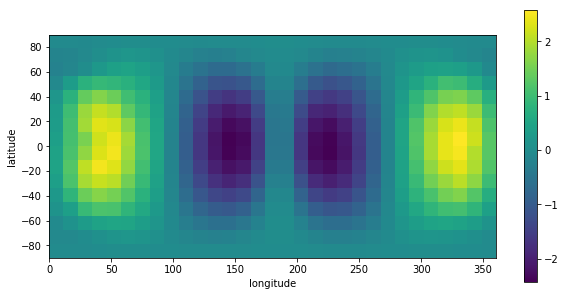

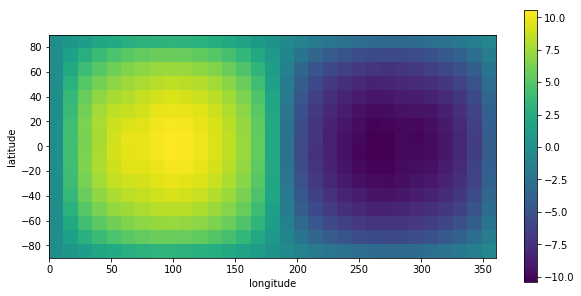

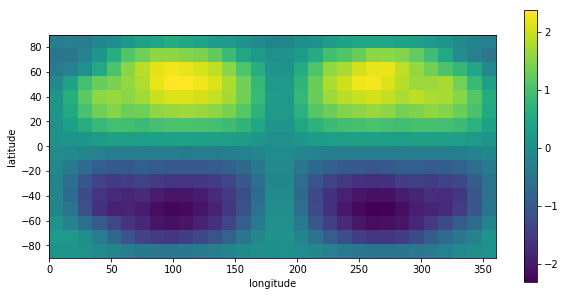

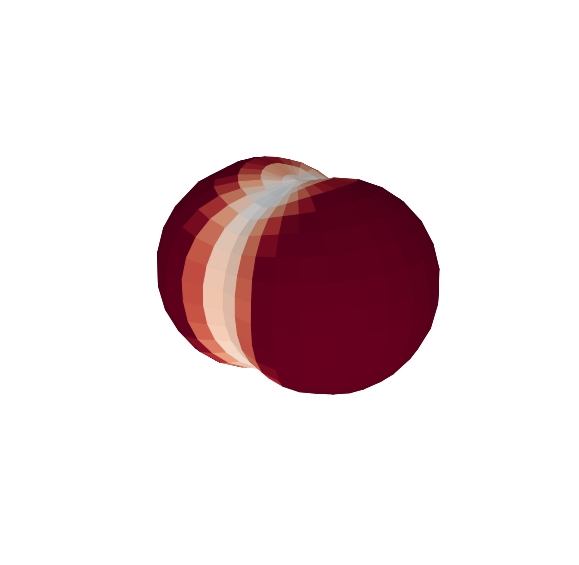

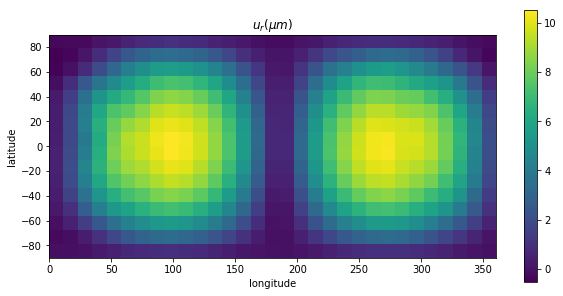

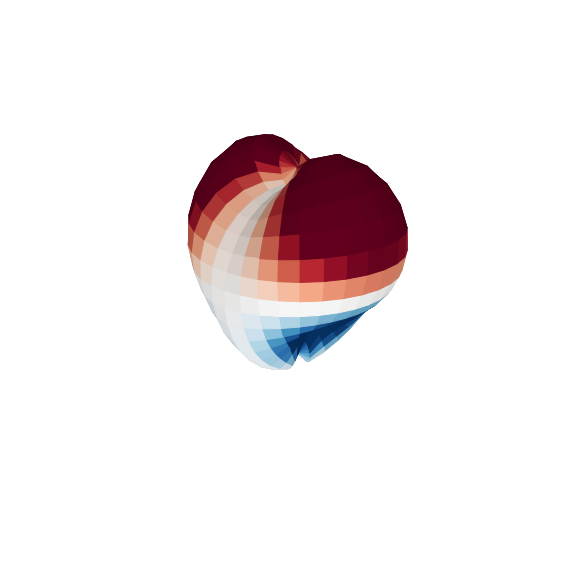

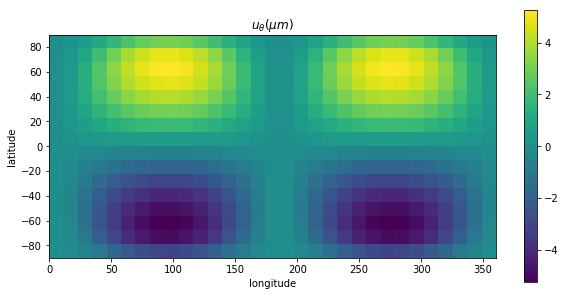

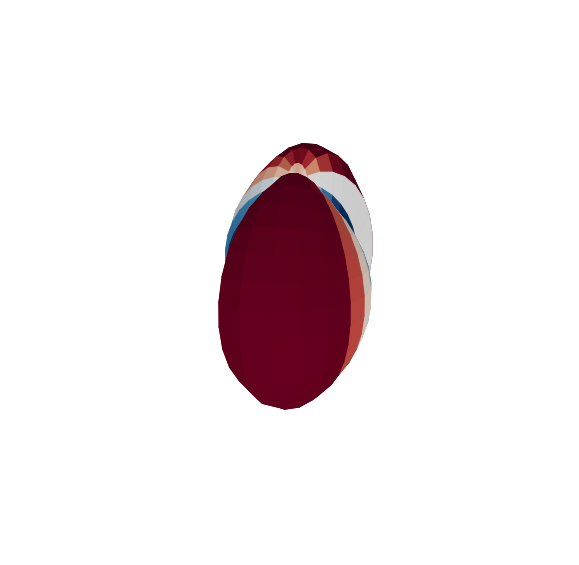

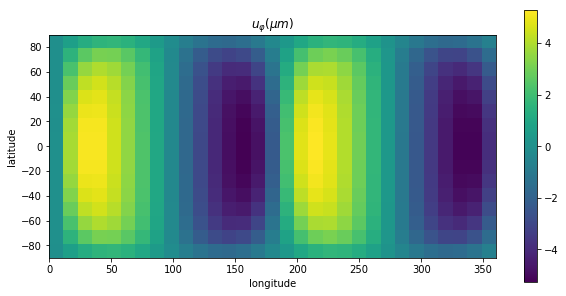

In [79]:
U0 = res.x.reshape(init.shape)
T0 = U0[...,0]; P0 = U0[...,1]; r0 = 5.272;
X0,Y0,Z0 = SphCoord_to_CartCoord(r0, T0, P0)

U_usr_mesh0 = np.stack([newdata[...,0]-X0, newdata[...,1]-Y0, newdata[...,2]-Z0], axis=-1)
U_usr_vec = np.empty(3*LJ, dtype=np.complex)
for k in range(3):
    U_usr_grid = pyshtools.SHGrid.from_array(U_usr_mesh[...,k].T.astype(np.complex), grid='GLQ')
    fig, ax = plotfv(U_usr_mesh0[...,k].T.real, show=False)
    #U_usr_grid.plot3d(azimuth=45, elevation=20)
    U_usr_cilm = U_usr_grid.expand()
    U_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(U_usr_cilm.to_array(), lmax = lJmax)

U_sph_mesh = np.sum(Q*U_usr_mesh0[...,np.newaxis,:], axis=-1)
rtp = ['r',r'\theta',r'\varphi']
for k in range(3):
    U_sph_grid = pyshtools.SHGrid.from_array(U_sph_mesh[...,k].T.real, grid='GLQ')
    U_sph_grid.plot3d(elevation=20,azimuth=45)
    fig, ax = plotfv(U_sph_mesh[...,k].T.real, show=False)
    ax.set_title(r'$u_%s (\mu m)$' % rtp[k])
plt.show()